In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from tqdm import tqdm
import time
from datetime import datetime

In [2]:
def clean_date(input_str: str) -> datetime:
    date_str = input_str.replace("Published \n \n ", "").replace(" GMT\n", "").strip()
    date_time_obj = datetime.strptime(date_str, "%d %B %Y %H:%M")

    return date_time_obj

In [3]:
ID = 0
article_archive = {}

for i in tqdm(range(10000)):
    url = f'https://www.upstreamonline.com/archive?offset={i + 1}0&publishdate=01.01.2014-31.12.2023'
    response = requests.get(url)

    if response.status_code != 200:
        print(f'Failed to fetch page {url}')
        pass

    soup = BeautifulSoup(response.text, 'html.parser')

    articles = soup.find_all('a', class_='card-link text-reset') # Find all articles
    publish_dates = soup.find_all('span', class_='published-at') # Find all publish dates

    for i, a in enumerate(articles):
        date = publish_dates[i].text[14:-5]
        
        link = 'https://www.upstreamonline.com' + a.get('href')
        text = a.text[3:]

        article_archive[ID] = [date, text, link]
        ID += 1

    time.sleep(0.1)  # Sleep to be respectful to the server


  0%|          | 4/10000 [00:05<3:45:29,  1.35s/it]


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(article_archive, index=['DATE', 'HEADLINE', 'LINK']).T

df['DATETIME'] = df['DATE'].apply(clean_date)

display(df)

# save as csv
df.to_csv('data/upstreamonline.csv', index=False)


,DATE,HEADLINE,LINK,DATETIME
0,28 December 2023 9:30,Gas introduced into flagship African FLNG faci...,https://www.upstreamonline.com/lng/gas-introdu...,2023-12-28 09:30:00
1,28 December 2023 8:00,Saudi Aramco dishes out trio of offshore deals...,https://www.upstreamonline.com/exclusive/saudi...,2023-12-28 08:00:00
2,28 December 2023 7:59,Worley weighs up options after losing internat...,https://www.upstreamonline.com/finance/worley-...,2023-12-28 07:59:00
3,28 December 2023 6:09,Seatrium successfully refinances\n,https://www.upstreamonline.com/finance/seatriu...,2023-12-28 06:09:00
4,28 December 2023 5:45,China completes sea trials for $412 million dr...,https://www.upstreamonline.com/rigs-and-vessel...,2023-12-28 05:45:00
...,...,...,...,...
24363,18 September 2019 12:05,Woodside confirms Kitimat sell-down plan\n,https://www.upstreamonline.com/lng/woodside-co...,2019-09-18 12:05:00
24364,18 September 2019 8:51,Wood wins Martin Linge award\n,https://www.upstreamonline.com/field-developme...,2019-09-18 08:51:00
24365,18 September 2019 8:50,ExxonMobil to sell Gippsland assets\n,https://www.upstreamonline.com/exploration/exx...,2019-09-18 08:50:00
24366,18 September 2019 7:48,Sea Lion financing nears agreement\n,https://www.upstreamonline.com/field-developme...,2019-09-18 07:48:00


In [ ]:
from nltk import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


tokenized = df['HEADLINE'].apply(sent_tokenize)

# Tokenize the headlines
tokenized = tokenized.apply(lambda x: [word_tokenize(s) for s in x])

# Remove stopwords
stop_words = set(stopwords.words('english'))
tokenized = tokenized.apply(lambda x: [[w for w in s if w.lower() not in stop_words] for s in x][0])

# sentiment analysis
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

print(tokenized)

sentiments = tokenized.apply(lambda x: [sia.polarity_scores(s) for s in x])
sentiments = sentiments.apply(lambda x: [s['compound'] for s in x])



0        [Gas, introduced, flagship, African, FLNG, fac...
1        [Saudi, Aramco, dishes, trio, offshore, deals,...
2        [Worley, weighs, options, losing, internationa...
3                     [Seatrium, successfully, refinances]
4        [China, completes, sea, trials, $, 412, millio...
                               ...                        
24363       [Woodside, confirms, Kitimat, sell-down, plan]
24364                   [Wood, wins, Martin, Linge, award]
24365                [ExxonMobil, sell, Gippsland, assets]
24366             [Sea, Lion, financing, nears, agreement]
24367                    [Chariot, Lixus, resource, boost]
Name: HEADLINE, Length: 24368, dtype: object


In [ ]:
df['SENTIMENT'] = sentiments.apply(sum)
df.set_index('DATETIME', inplace=True)
display(df)

,DATE,HEADLINE,LINK,DATETIME,SENTIMENT
0,28 December 2023 9:30,Gas introduced into flagship African FLNG faci...,https://www.upstreamonline.com/lng/gas-introdu...,2023-12-28 09:30:00,0.1027
1,28 December 2023 8:00,Saudi Aramco dishes out trio of offshore deals...,https://www.upstreamonline.com/exclusive/saudi...,2023-12-28 08:00:00,0.2565
2,28 December 2023 7:59,Worley weighs up options after losing internat...,https://www.upstreamonline.com/finance/worley-...,2023-12-28 07:59:00,-0.3818
3,28 December 2023 6:09,Seatrium successfully refinances\n,https://www.upstreamonline.com/finance/seatriu...,2023-12-28 06:09:00,0.4939
4,28 December 2023 5:45,China completes sea trials for $412 million dr...,https://www.upstreamonline.com/rigs-and-vessel...,2023-12-28 05:45:00,0.0000
...,...,...,...,...,...
24363,18 September 2019 12:05,Woodside confirms Kitimat sell-down plan\n,https://www.upstreamonline.com/lng/woodside-co...,2019-09-18 12:05:00,0.0000
24364,18 September 2019 8:51,Wood wins Martin Linge award\n,https://www.upstreamonline.com/field-developme...,2019-09-18 08:51:00,1.1142
24365,18 September 2019 8:50,ExxonMobil to sell Gippsland assets\n,https://www.upstreamonline.com/exploration/exx...,2019-09-18 08:50:00,0.1779
24366,18 September 2019 7:48,Sea Lion financing nears agreement\n,https://www.upstreamonline.com/field-developme...,2019-09-18 07:48:00,0.4939


C:\Users\joneh\AppData\Local\Temp\ipykernel_22380\1936455997.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_sent = df.resample('D').mean()


[*********************100%%**********************]  1 of 1 completed


Text(0, 0.5, 'Crude Oil price')

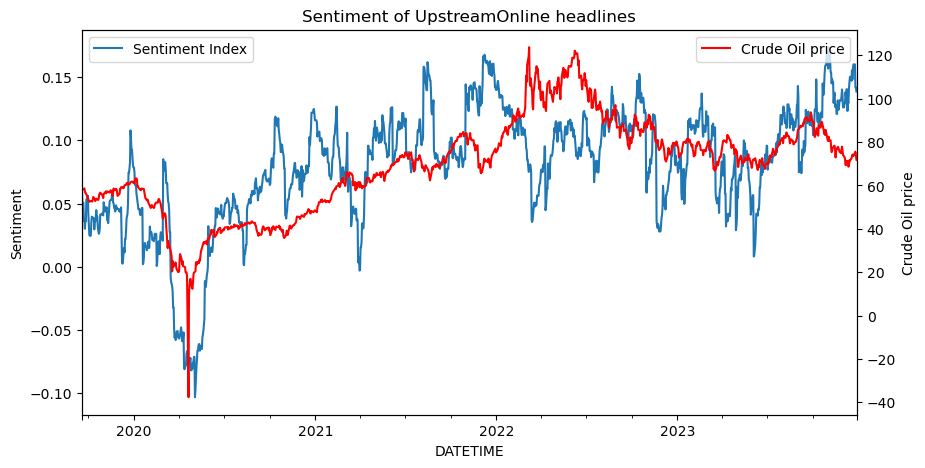

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt

# group by date and calculate the mean sentiment
df_sent = df.resample('D').mean()

fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

df_crude = yf.download('CL=F', start='2019-09-18', end='2023-12-31')[['Adj Close']]


df_sent['SENTIMENT'].ewm(alpha=0.05).mean().plot(kind='line', ax=ax1, title='Sentiment of UpstreamOnline headlines', label='Sentiment Index')
df_crude['Adj Close'].plot(kind='line', color='r', ax=ax2, label='Crude Oil price')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_ylabel('Sentiment')
ax2.set_ylabel('Crude Oil price')

